# BLOCK 4: Classification des WSI's en fontcion des prédictions de leurs patches avec Catboost

In [ ]:

import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder

def extract_distribution_features(probas):
    return {
        "skew": skew(probas),
        "kurtosis": kurtosis(probas),
        "above_0.9": np.mean(np.array(probas) > 0.9),
        "max_peak": np.histogram(probas, bins=100, range=(0,1))[0].max()
    }

def compute_density(probas, bins=100):
    hist, bin_edges = np.histogram(probas, bins=bins, range=(0,1), density=True)
    return hist, bin_edges

def extract_ratio_features(dens_A, dens_B):
    ratio = dens_A / (dens_B + 1e-6)
    return {
        "ratio_mean": np.mean(ratio),
        "ratio_std": np.std(ratio),
        "ratio_max": np.max(ratio),
        "ratio_min": np.min(ratio),
        "ratio_skew": skew(ratio),
        "ratio_kurtosis": kurtosis(ratio)
    }

def prepare_features(df_all):
    X_list = []
    y_list = []

    df_all = df_all[df_all["prediction"].isin(list(range(1,9)))]

    for image_id, group in df_all.groupby("image_id"):
        probs_per_patch = group["probabilities"].tolist()
        probas_array = np.vstack(probs_per_patch)

        image_features = {}

        # Features classiques par classe 1 à 8
        for class_idx in range(1, 9):
            class_probas = probas_array[:, class_idx]
            feats = extract_distribution_features(class_probas)
            image_features.update({f"class_{class_idx}_{k}": v for k, v in feats.items()})

        # Features ratios densité entre paires (1,2), (3,4), (5,6)
        pairs = [(1, 2), (3, 4), (5, 6)]
        for a, b in pairs:
            try:
                dens_a, _ = compute_density(probas_array[:, a])
                dens_b, _ = compute_density(probas_array[:, b])
                ratio_feats = extract_ratio_features(dens_a, dens_b)
                image_features.update({f"ratio_{a}_{b}_{k}": v for k, v in ratio_feats.items()})
            except IndexError:
                print(f"⚠️ Classes manquantes pour image {image_id}, pas de features ratio.")

        X_list.append(image_features)
        y_list.append(group["label"].iloc[0])

    X = pd.DataFrame(X_list)
    y = np.array(y_list)

    return X, y

def filter_features(X, use_classic_dict, use_ratio_dict):
    X_filtered = X.copy()

    # Features classiques par nom
    classic_features = ["skew", "kurtosis", "above_0.9", "max_peak"]
    for feature_name in classic_features:
        if not use_classic_dict.get(feature_name, True):
            # Supprime toutes les colonnes qui contiennent f"class_..." + feature_name
            cols_to_drop = [col for col in X_filtered.columns if col.startswith("class_") and col.endswith(feature_name)]
            X_filtered = X_filtered.drop(columns=cols_to_drop, errors='ignore')

    # Features ratio par nom et paire
    ratio_features = ["ratio_mean", "ratio_std", "ratio_max", "ratio_min", "ratio_skew", "ratio_kurtosis"]
    pairs = [(1, 2), (3, 4), (5, 6)]
    for a, b in pairs:
        for feat in ratio_features:
            key = f"ratio_{a}_{b}_{feat}"
            if not use_ratio_dict.get(key, True):
                # Supprime cette colonne si existante
                if key in X_filtered.columns:
                    X_filtered = X_filtered.drop(columns=[key])

    return X_filtered

def cross_val_score_model(model, X, y, n_splits=10, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    accuracies = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if isinstance(model, CatBoostClassifier):
            model.fit(Pool(X_train, label=y_train))
        else:
            model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

    return np.mean(accuracies)


0:	learn: 1.0926364	total: 113ms	remaining: 11.2s
99:	learn: 0.6525148	total: 6.68s	remaining: 0us
Fold accuracy: 0.5556
0:	learn: 1.0929159	total: 72.2ms	remaining: 7.14s
99:	learn: 0.6566197	total: 6.71s	remaining: 0us
Fold accuracy: 0.7778
0:	learn: 1.0922038	total: 69ms	remaining: 6.83s
99:	learn: 0.6453463	total: 6.57s	remaining: 0us
Fold accuracy: 0.2222
0:	learn: 1.0932211	total: 69.3ms	remaining: 6.86s
99:	learn: 0.6660698	total: 6.69s	remaining: 0us
Fold accuracy: 0.5556
0:	learn: 1.0918483	total: 70.9ms	remaining: 7.02s
99:	learn: 0.6548110	total: 6.73s	remaining: 0us
Fold accuracy: 0.3333
0:	learn: 1.0920517	total: 66.8ms	remaining: 6.62s
99:	learn: 0.6455957	total: 6.51s	remaining: 0us
Fold accuracy: 0.2222
0:	learn: 1.0926364	total: 60.3ms	remaining: 5.97s
99:	learn: 0.6622688	total: 6.48s	remaining: 0us
Fold accuracy: 0.5556
0:	learn: 1.0928142	total: 63ms	remaining: 6.24s
99:	learn: 0.6501960	total: 7.39s	remaining: 0us
Fold accuracy: 0.4444
0:	learn: 1.0921278	total: 67

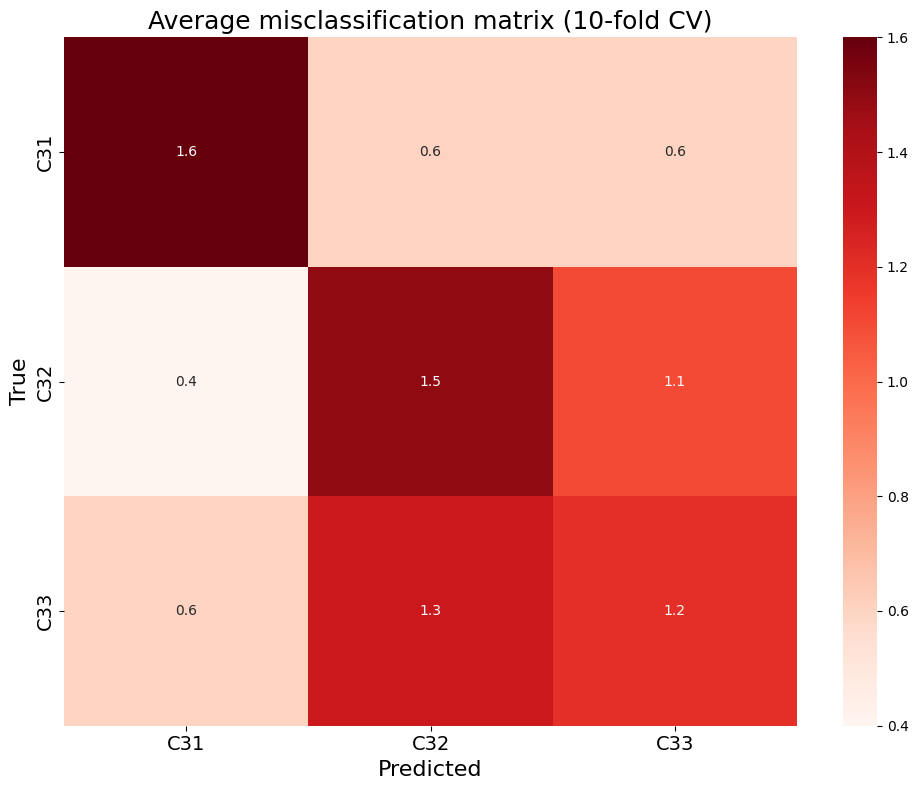


Training final model on all data for interpretability...
0:	learn: 1.0922111	total: 67.4ms	remaining: 6.67s
99:	learn: 0.6528289	total: 7.07s	remaining: 0us


: 

In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import optuna
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns


# This block extends the original code by adding interpretability methods for CatBoost

from catboost import CatBoostClassifier, Pool, cv, CatBoost
import shap
import os


# Create folder for SHAP plots
os.makedirs("shap_local_plots", exist_ok=True)
os.makedirs("error_analysis", exist_ok=True)


def cat_analysis(model, X_filtered,y_encoded):

    # Train model on full dataset for global interpretability
    # model.fit(Pool(X_filtered, label=y_encoded))

    # GLOBAL INTERPRETABILITY
    # 1. Feature importance - LossFunctionChange (classical)
    feature_importance = model.get_feature_importance(Pool(X_filtered, label=y_encoded), type='FeatureImportance')
    feature_names = X_filtered.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x="Importance", y="Feature", data=importance_df.head(30))
    plt.title("Top 30 Feature Importances (LossFunctionChange)")
    plt.tight_layout()
    plt.savefig("global_feature_importance.png")
    plt.close()

    # 2. Feature importance - PredictionValuesChange
    pred_val_change = model.get_feature_importance(Pool(X_filtered, label=y_encoded), type='PredictionValuesChange')
    pred_val_df = pd.DataFrame({
        'Feature': feature_names,
        'Pred_Val_Change': pred_val_change
    }).sort_values(by='Pred_Val_Change', ascending=False)

    # Plot prediction value change
    plt.figure(figsize=(12, 8))
    sns.barplot(x="Pred_Val_Change", y="Feature", data=pred_val_df.head(30))
    plt.title("Top 30 Feature Importances (PredictionValuesChange)")
    plt.tight_layout()
    plt.savefig("prediction_value_change_importance.png")
    plt.close()

    # 3. SHAP Values (global summary)
    # 3. SHAP Values (global summary with SHAP library)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_filtered)

    # Pour les modèles multi-classes, shap_values est une liste de [array_class_0, array_class_1, ...]
    # On affiche pour la classe dominante ou moyenne
    if isinstance(shap_values, list) and len(shap_values) > 1:
        # Option : moyenne absolue des SHAPs sur toutes les classes
        mean_shap = np.mean([np.abs(sv) for sv in shap_values], axis=0)

        shap.summary_plot(mean_shap, features=X_filtered, feature_names=X_filtered.columns, show=False)
    else:
        shap.summary_plot(shap_values, features=X_filtered, feature_names=X_filtered.columns, show=False)

    plt.tight_layout()
    plt.savefig("shap_summary_plot.png")
    plt.close()

    # LOCAL INTERPRETABILITY - For errors
    y_pred = model.predict(X_filtered).flatten()
    misclassified_indices = np.where(y_pred != y_encoded)[0]

    for idx in misclassified_indices:
        sample = X_filtered.iloc[[idx]]
        expl = model.get_feature_importance(Pool(sample, label=[y_encoded[idx]]), type='ShapValues')
        contrib = expl[0][:-1]
        expected_val = expl[0][-1]
        predicted_class = y_pred[idx]
        true_class = y_encoded[idx]
        filename = f"shap_local_plots/sample_{idx}_true_{class_names[true_class]}_pred_{class_names[predicted_class]}.png"

        # Plot SHAP force-style bar chart (manual)
        sorted_idx = np.argsort(np.abs(contrib))[::-1][:10]
        top_features = sample.columns[sorted_idx]
        top_contrib = contrib[sorted_idx]

        plt.figure(figsize=(10, 6))
        colors = ["green" if v > 0 else "red" for v in top_contrib]
        sns.barplot(x=top_contrib, y=top_features, palette=colors)
        plt.title(f"SHAP for Sample {idx} | True: {class_names[true_class]}, Pred: {class_names[predicted_class]}")
        plt.tight_layout()
        plt.savefig(filename)
        plt.close()

        # Save detailed text report
        with open(f"error_analysis/sample_{idx}_true_{class_names[true_class]}_pred_{class_names[predicted_class]}.txt", "w") as f:
            f.write(f"True label: {class_names[true_class]}\n")
            f.write(f"Predicted: {class_names[predicted_class]}\n")
            f.write("Top contributing features:\n")
            for feat, val in zip(top_features, top_contrib):
                f.write(f" - {feat}: {val:.4f}\n")


    len(misclassified_indices), importance_df.head(5)  # Show summary info only for now

# Chargement des données
df_all = pd.read_parquet("patches_with_labels.parquet")

c32a_ids = [
    "11C11784", "13C09634", "14C09799", "14C10452", "14C10964", "15C01600", 
    "16C08414", "17C03314", "19C04498", "19C06512", "19C07766", "19C09027", 
    "19C09431", "19C10627", "20C02538", "20C03174", "20C03527"
]

# df_all.loc[df_all["image_id"].isin(c32a_ids), "label"] = "C32a"
# Fonctions utilitaires (réutilisées depuis ton code Optuna)
# -- Les mêmes que celles déjà définies dans ton script original --
# Assure-toi d'inclure ici : prepare_features(), filter_features()

# Dictionnaires de sélection des features (résultats de l'Optuna)
use_classic_dict = {
    "skew": False,
    "kurtosis": True,
    "above_0.9": False,
    "max_peak": True
}

use_ratio_dict = {
    "ratio_1_2_ratio_mean": True,
    "ratio_1_2_ratio_std": True,
    "ratio_1_2_ratio_max": False,
    "ratio_1_2_ratio_min": False,
    "ratio_1_2_ratio_skew": False,
    "ratio_1_2_ratio_kurtosis": False,
    "ratio_3_4_ratio_mean": False,
    "ratio_3_4_ratio_std": True,
    "ratio_3_4_ratio_max": True,
    "ratio_3_4_ratio_min": False,
    "ratio_3_4_ratio_skew": True,
    "ratio_3_4_ratio_kurtosis": False,
    "ratio_5_6_ratio_mean": True,
    "ratio_5_6_ratio_std": False,
    "ratio_5_6_ratio_max": False,
    "ratio_5_6_ratio_min": False,
    "ratio_5_6_ratio_skew": True,
    "ratio_5_6_ratio_kurtosis": True
}


def extract_distribution_features(probas):
    return {
        "skew": skew(probas),
        "kurtosis": kurtosis(probas),
        "above_0.9": np.mean(np.array(probas) > 0.9),
        "max_peak": np.histogram(probas, bins=100, range=(0,1))[0].max()
    }

def compute_density(probas, bins=100):
    hist, bin_edges = np.histogram(probas, bins=bins, range=(0,1), density=True)
    return hist, bin_edges

def extract_ratio_features(dens_A, dens_B):
    ratio = dens_A / (dens_B + 1e-6)
    return {
        "ratio_mean": np.mean(ratio),
        "ratio_std": np.std(ratio),
        "ratio_max": np.max(ratio),
        "ratio_min": np.min(ratio),
        "ratio_skew": skew(ratio),
        "ratio_kurtosis": kurtosis(ratio)
    }

def prepare_features(df_all):
    X_list = []
    y_list = []

    df_all = df_all[df_all["prediction"].isin(list(range(1,9)))]

    for image_id, group in df_all.groupby("image_id"):
        probs_per_patch = group["probabilities"].tolist()
        probas_array = np.vstack(probs_per_patch)

        image_features = {}

        # Features classiques par classe 1 à 8
        for class_idx in range(1, 9):
            class_probas = probas_array[:, class_idx]
            feats = extract_distribution_features(class_probas)
            image_features.update({f"class_{class_idx}_{k}": v for k, v in feats.items()})

        # Features ratios densité entre paires (1,2), (3,4), (5,6)
        pairs = [(1, 2), (3, 4), (5, 6)]
        for a, b in pairs:
            try:
                dens_a, _ = compute_density(probas_array[:, a])
                dens_b, _ = compute_density(probas_array[:, b])
                ratio_feats = extract_ratio_features(dens_a, dens_b)
                image_features.update({f"ratio_{a}_{b}_{k}": v for k, v in ratio_feats.items()})
            except IndexError:
                print(f"⚠️ Classes manquantes pour image {image_id}, pas de features ratio.")

        X_list.append(image_features)
        y_list.append(group["label"].iloc[0])

    X = pd.DataFrame(X_list)
    y = np.array(y_list)

    return X, y

def filter_features(X, use_classic_dict, use_ratio_dict):
    X_filtered = X.copy()

    # Features classiques par nom
    classic_features = ["skew", "kurtosis", "above_0.9", "max_peak"]
    for feature_name in classic_features:
        if not use_classic_dict.get(feature_name, True):
            # Supprime toutes les colonnes qui contiennent f"class_..." + feature_name
            cols_to_drop = [col for col in X_filtered.columns if col.startswith("class_") and col.endswith(feature_name)]
            X_filtered = X_filtered.drop(columns=cols_to_drop, errors='ignore')

    # Features ratio par nom et paire
    ratio_features = ["ratio_mean", "ratio_std", "ratio_max", "ratio_min", "ratio_skew", "ratio_kurtosis"]
    pairs = [(1, 2), (3, 4), (5, 6)]
    for a, b in pairs:
        for feat in ratio_features:
            key = f"ratio_{a}_{b}_{feat}"
            if not use_ratio_dict.get(key, True):
                # Supprime cette colonne si existante
                if key in X_filtered.columns:
                    X_filtered = X_filtered.drop(columns=[key])

    return X_filtered


# Préparation des features et des labels
X, y = prepare_features(df_all)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

# # Filtrage des features selon les meilleurs paramètres
X_filtered = filter_features(X, use_classic_dict, use_ratio_dict)

# Définition du modèle avec les meilleurs hyperparamètres
catboost_params = {
    "iterations": 100,
    "depth": 12,
    "learning_rate": 0.024953062571816047,
    "verbose": 100,
    "task_type": "GPU",
    "loss_function": "MultiClass"
}

model = CatBoostClassifier(**catboost_params)
# Entraînement avec validation croisée
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = []
conf_matrices = []


for train_idx, val_idx in skf.split(X_filtered, y_encoded):
    X_train, X_val = X_filtered.iloc[train_idx], X_filtered.iloc[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]
    
    model.fit(Pool(X_train, label=y_train))
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f"Fold accuracy: {acc:.4f}")
    scores.append(acc)

    cm = confusion_matrix(y_val, preds, labels=range(len(class_names)))
    conf_matrices.append(cm)
mean_cm = np.mean(conf_matrices,axis=0)
# Moyenne des matrices de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(mean_cm, annot=True, fmt=".1f", cmap="Reds",
            xticklabels=class_names, yticklabels=class_names)

# Titre et labels avec taille de police augmentée
plt.title("Average misclassification matrix (10-fold CV)", fontsize=18)
plt.xlabel("Predicted", fontsize=16)
plt.ylabel("True", fontsize=16)

# Taille des ticks (valeurs des axes)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig("confusion_matrix_cv.png")
plt.show()


# 📌 Entraînement final sur tout le dataset (pour SHAP & analyse)
print("\nTraining final model on all data for interpretability...")
final_model = CatBoostClassifier(**catboost_params)
final_model.fit(Pool(X_filtered, label=y_encoded))
#7, 6, 4, 7, 4
# Interprétation globale & locale
cat_analysis(final_model, X_filtered, y_encoded)